In [51]:
import numpy as np
import matplotlib.pyplot as plt
import geone
import geone.covModel as gcm
import scipy
import numba 
from numba import jit

In [108]:
# create functions to compute the equivalent permeability of a 2D field
# This is done by computing the arithmetic mean / or the harmonic mean in the x and y directions sequentially until the final value is obtained

@jit
def hmean(v1, v2):
    return 1 / ((1 / v1 + 1 / v2) / 2)

@jit
def mean(v1, v2):
    return (v1 + v2) / 2

def f(a, direction="x", type="series"):

    """
    Function to operate a mean row or column wise by pairs of rows or columns
    """

    # select the vectors
    if (direction == "x" and type == "parallel") or (direction == "y" and type == "series"):

        v1 = a[::2]
        v2 = a[1::2]

    if (direction == "x" and type == "series") or (direction == "y" and type == "parallel"):

        v1 = a[:, ::2]
        v2 = a[:, 1::2]

    # merge
    if type == "parallel":
        return mean(v1, v2)
    elif type == "series":
        # return scipy.stats.hmean([v1, v2], axis=0)
        # return 1 / np.mean(1 / np.array([v1, v2]), axis=0)
        return hmean(v1, v2)

def test_f():

    """
    Test the function f
    """

    a = np.array([[0.2707579 , 0.67406735], 
                  [0.04264607, 0.17996007]])

    assert np.allclose(f(a, direction="x", type="parallel"), np.array([[0.15670199, 0.42701371]]))
    assert np.allclose(f(a, direction="x", type="series"), np.array([[0.38633401], [0.06895219]]))
    assert np.allclose(f(a, direction="y", type="parallel"), np.array([[0.47241263], [0.11130307]]))
    assert np.allclose(f(a, direction="y", type="series"), np.array([[0.07368612, 0.28407801]]))

    print("Test passed")


def merge(v1, v2, w1, w2, normalize=True):
    
    """
    Function to merge two vectors v1 and v2 with weights w1 and w2
    Is used here to merge two columns of different sizes
    """

    if normalize:
        sum_w = w1 + w2
        w1 = w1 / sum_w
        w2 = w2 / sum_w

    return w1*v1 + w2*v2 - (w1*w2*(v1 - v2)**2)/(w1*v2 + w2*v1)

In [109]:
test_f()

Test passed


In [16]:
def find_c(k_field, direction="x", first_type="series"):

    k_field_copy = k_field.copy()

    if first_type == "series":
        o = 1
    else:
        o = 2

    while k_field_copy.flatten().shape[0] > 1:
        # print(k_field_copy)
        if o % 2 == 0 and ((direction == "x" and k_field_copy.shape[0]>1) or (direction == "y" and k_field_copy.shape[1]>1)):
            
            # remove the last row or column if the number of rows or columns is odd
            rm_row = None
            rm_col = None
            if direction == "x" and k_field_copy.shape[0] % 2 == 1:
                # remove the last row if the number of rows is odd
                rm_row = k_field_copy[-1, :]
                k_field_copy = k_field_copy[:-1, :]
            elif direction == "y" and k_field_copy.shape[1] % 2 == 1:
                # remove the last column if the number of columns is odd
                rm_col = k_field_copy[:, -1]
                k_field_copy = k_field_copy[:, :-1]

            # compute the mean
            k_field_copy = f(k_field_copy, type="parallel", direction=direction)

            # add the removed row or column
            if rm_row is not None:
                new_row = merge(k_field_copy[-1, :], rm_row, 2, 1)
                k_field_copy = np.vstack((k_field_copy, new_row))
            elif rm_col is not None:
                new_col = merge(k_field_copy[:, -1], rm_col, 2, 1)
                k_field_copy = np.hstack((k_field_copy, new_col[:, None]))
                

        elif o % 2 == 1 and ((direction == "x" and k_field_copy.shape[1]>1) or (direction == "y" and k_field_copy.shape[0]>1)):

            # remove the last row or column if the number of rows or columns is odd
            rm_row = None
            rm_col = None
            if direction == "x" and k_field_copy.shape[1] % 2 == 1:
                # remove the last column if the number of columns is odd
                rm_col = k_field_copy[:, -1]
                k_field_copy = k_field_copy[:, :-1]
            elif direction == "y" and k_field_copy.shape[0] % 2 == 1:
                # remove the last row if the number of rows is odd
                rm_row = k_field_copy[-1, :]
                k_field_copy = k_field_copy[:-1, :]
                
            # compute the mean
            k_field_copy = f(k_field_copy, type="series", direction=direction)

            # add the removed row or column
            if rm_row is not None:
                new_row = merge(k_field_copy[-1, :], rm_row, 2, 1)
                k_field_copy = np.vstack((k_field_copy, new_row))
            elif rm_col is not None:
                new_col = merge(k_field_copy[:, -1], rm_col, 2, 1)
                k_field_copy = np.hstack((k_field_copy, new_col[:, None]))

        o += 1

    return k_field_copy[0, 0]

In [17]:
k_field = np.random.rand(4, 4)

print(f(k_field, type="parallel", direction="y"))
print(f(k_field, type="parallel", direction="x"))
print(f(k_field, type="series", direction="x"))

[[0.56730597 0.49803714]
 [0.5007467  0.37735996]
 [0.52373591 0.50584948]
 [0.48934574 0.62999699]]
[[0.66663083 0.40142183 0.14565852 0.72973858]
 [0.09687951 0.91620214 0.62257485 0.51327162]]
[[0.30888172 0.29910522]
 [0.47308983 0.18515117]
 [0.09827332 0.48427737]
 [0.242896   0.55746421]]


In [18]:

find_c(k_field, direction="y", first_type="series")

0.4599388465374308

In [19]:
find_c(k_field, direction="y", first_type="parallel")

0.505728564761133

In [20]:
k_field = np.random.rand(2, 2)
print(k_field)
print(find_c(k_field, direction="x", first_type="series"))
print(find_c(k_field, direction="y", first_type="series"))

[[0.63816467 0.59963138]
 [0.27390833 0.00746226]]
0.31641347830709027
0.1990203528062164


In [21]:
np.random.seed(1312)

# create a 2D field
nx, ny = 5, 5
dx, dy = 1, 1
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

field = 10**(np.random.rand(nx, ny)*-2 + -3)
c_x = find_c(field, direction="x", first_type="parallel")
c_y = find_c(field, direction="y", first_type="parallel")
print(c_x, c_y)

0.0001858863225781165 0.00011545789430841304


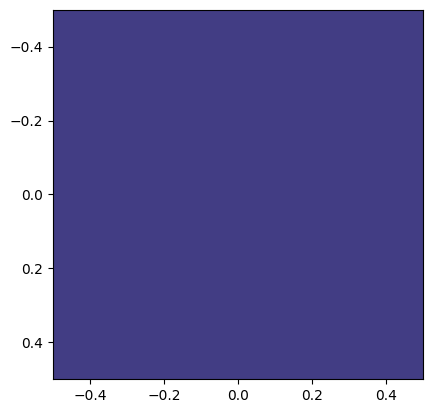

In [22]:
plt.imshow(np.array(c_x).reshape(1, 1), cmap="viridis", vmin=field.min(), vmax=field.max())

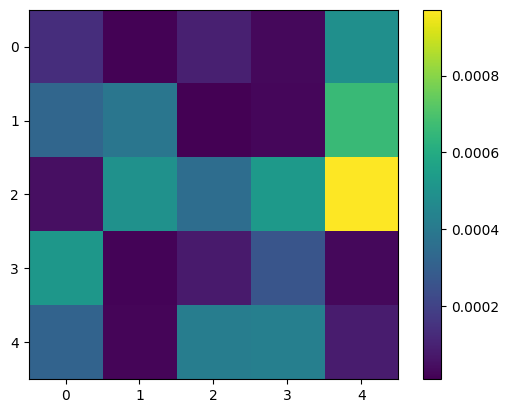

In [23]:
plt.imshow(field)
plt.colorbar()

In [24]:
np.random.seed(1312)

# create a 2D field
nx, ny = 4, 4
dx, dy = 1, 1
x = np.linspace(0, nx-1, nx)
y = np.linspace(0, ny-1, ny)
x, y = np.meshgrid(x, y)

l_c = []

for i in range(2000):
    field = 10**(np.random.rand(nx, ny)*-2 + -3)
    c_x_min = find_c(field, direction="x", first_type="series")
    c_x_max = find_c(field, direction="x", first_type="parallel")
    l_c.append((c_x_min, c_x_max))

(array([[  9.,  14.,  26.,  48.,  56.,  66., 103., 109., 123., 159., 138.,
         154., 139., 140., 131., 106., 115.,  93.,  81.,  58.,  43.,  33.,
          20.,  15.,  10.,   8.,   2.,   1.,   0.,   0.],
        [  1.,   0.,   2.,   4.,  11.,  21.,  25.,  32.,  45.,  61.,  70.,
          97.,  91., 139., 127., 155., 163., 164., 132., 137., 129., 115.,
          71.,  71.,  64.,  35.,  19.,  11.,   7.,   1.]]),
 array([-4.55920344, -4.5205076 , -4.48181175, -4.4431159 , -4.40442005,
        -4.3657242 , -4.32702836, -4.28833251, -4.24963666, -4.21094081,
        -4.17224496, -4.13354912, -4.09485327, -4.05615742, -4.01746157,
        -3.97876572, -3.94006988, -3.90137403, -3.86267818, -3.82398233,
        -3.78528648, -3.74659063, -3.70789479, -3.66919894, -3.63050309,
        -3.59180724, -3.55311139, -3.51441555, -3.4757197 , -3.43702385,
        -3.398328  ]),
 <a list of 2 BarContainer objects>)

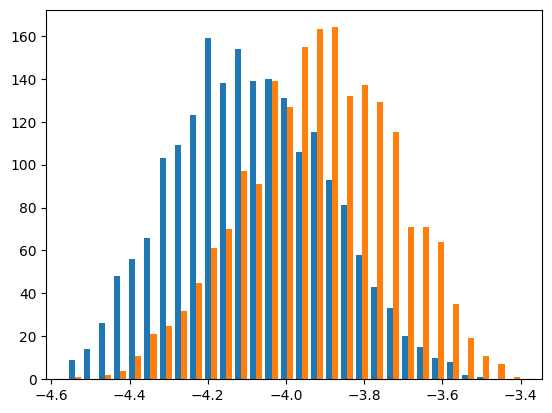

In [25]:
plt.hist(np.log10(np.array(l_c)), bins=30)

In [26]:
np.random.seed(81)
a = np.random.rand(4, 4)
print(find_c(a, direction="x", first_type="series"), find_c(a, direction="x", first_type="parallel"))

0.3642482351600886 0.4589994718936754


In [27]:
# now keq is a function of cmin and cmax according to keq = cmax**alpha*(cmin)**(1-alpha)
def get_alpha(dx, dy, dz=None, direction="x"):
    
    def f_u(t):
        return np.arctan(np.sqrt(t)) / (np.pi/2)

    if dz is None:
        if direction == "x":
            a = dx/dy
        elif direction == "y":
            a = dy/dx
        
        u = f_u(a)
        return u

    if direction == "x":
        a_1 = dx/dy
        a_2 = dx/dz
    elif direction == "y":
        a_1 = dy/dx
        a_2 = dy/dz
    elif direction == "z":
        a_1 = dz/dx
        a_2 = dz/dy
        
    u_1 = f_u(a_1)
    u_2 = f_u(a_2)

    return ((u_1 + u_2) - 2*u_1*u_2) / (1 - u_1*u_2)
    
def keq(cmin, cmax, alpha):
    return cmax**alpha*(cmin)**(1-alpha)

In [28]:
def simplified_renormalization(field, dx, dy, direction="x"):

    cx_min, cx_max = find_c(field, direction=direction, first_type="series"), find_c(field, direction=direction, first_type="parallel")
    return keq(cx_min, cx_max, get_alpha(dx, dy, direction=direction)) 


In [183]:
np.random.seed(1312)

# create a 2D field
nx, ny = 8, 8
dx, dy = 1, 1

field = 10**(np.random.rand(nx, ny)*-2 + -4)
Kxx = simplified_renormalization(field, dx, dy, direction="x")
Kyy = simplified_renormalization(field, dx, dy, direction="y")
print(np.round(Kxx, 8), np.round(Kyy, 8))

1.082e-05 1.133e-05


### Tests with an heterogeneous field

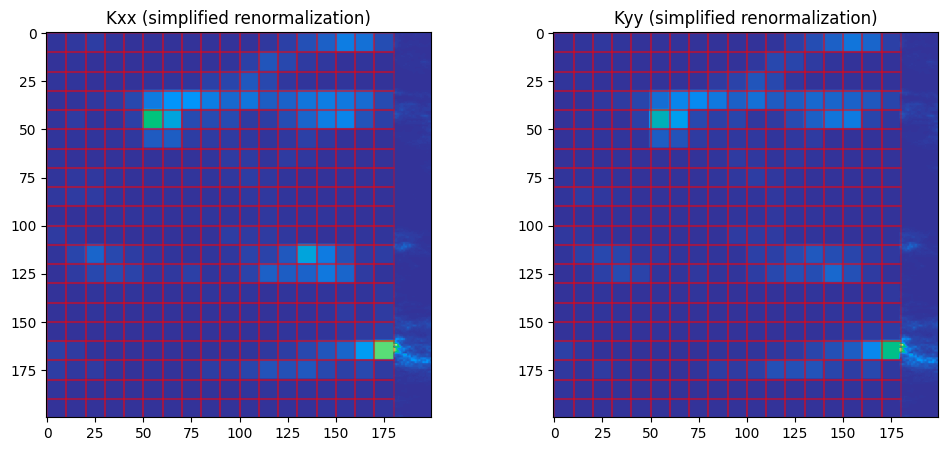

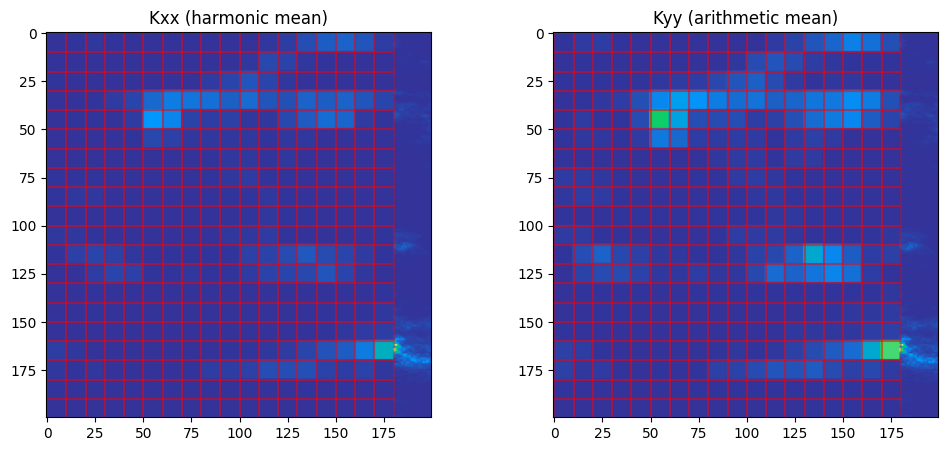

In [282]:
np.random.seed(121)

xmin = 0
xmax = 180
ymin = 0
ymax = 200
sx, sy = 10, 10

cm = geone.covModel.CovModel2D(elem=[("spherical", {"w":.5, "r":[150, 50]})
                                    ], 
                                name="model")
nx_grid, ny_grid = 200, 200
sx_grid, sy_grid = 2, 2
field = 10**geone.multiGaussian.multiGaussianRun(cm, (nx_grid, ny_grid), (sx_grid, sy_grid), output_mode="array", mean=-5)

new_field_kxx = field[0].copy() 
new_field_kyy = field[0].copy() 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
for i in range(ymin, ymax, sy):
    for j in range(xmin, xmax, sx):
        x1 = i
        lx = sx
        x2 = x1 + lx
        y1 = j
        ly = sy
        y2 = y1 + ly 
        selected_area = field[0][x1:x2, y1:y2]
        ax[0].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        ax[1].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        Kxx = simplified_renormalization(selected_area, dx, dy, direction="x")
        Kyy = simplified_renormalization(selected_area, dx, dy, direction="y")
        new_field_kxx[x1:x2, y1:y2] = Kxx
        new_field_kyy[x1:x2, y1:y2] = Kyy

g = ax[0].imshow(new_field_kxx, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
# plt.colorbar(g)
g = ax[1].imshow(new_field_kyy, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
# plt.colorbar(g)
ax[0].set_title("Kxx (simplified renormalization)")
ax[1].set_title("Kyy (simplified renormalization)")
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

new_field_2_kxx = field[0].copy() 
new_field_2_kyy = field[0].copy() 

for i in range(ymin, ymax, sy):
    for j in range(xmin, xmax, sx):
        x1 = i
        lx = sx
        x2 = x1 + lx
        y1 = j
        ly = sy
        y2 = y1 + ly 
        selected_area = field[0][x1:x2, y1:y2]
        ax[0].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        ax[1].plot([y1, y1, y2, y2, y1], [x1, x2, x2, x1, x1], color="red", alpha=.3)
        Kyy = np.mean(selected_area.flatten())
        Kxx = 1 / np.mean(1 / selected_area.flatten())
        new_field_2_kxx[x1:x2, y1:y2] = Kxx
        new_field_2_kyy[x1:x2, y1:y2] = Kyy

ax[0].imshow(new_field_2_kxx, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[1].imshow(new_field_2_kyy, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[0].set_title("Kxx (harmonic mean)")
ax[1].set_title("Kyy (arithmetic mean)")
plt.show()

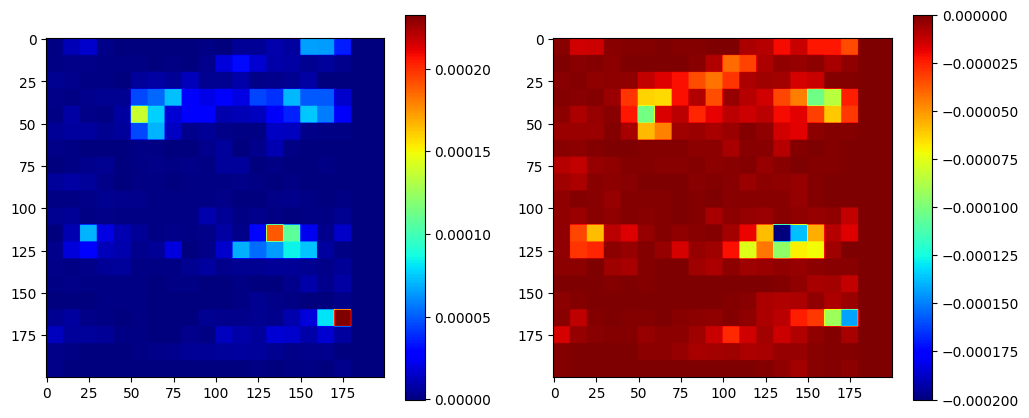

In [283]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
g = ax[0].imshow(new_field_kxx - new_field_2_kxx, cmap="jet")
g2 = ax[1].imshow(new_field_kyy - new_field_2_kyy, cmap="jet")

plt.colorbar(g)
plt.colorbar(g2)
plt.show()
# plt.plot(field[0][:, 0])

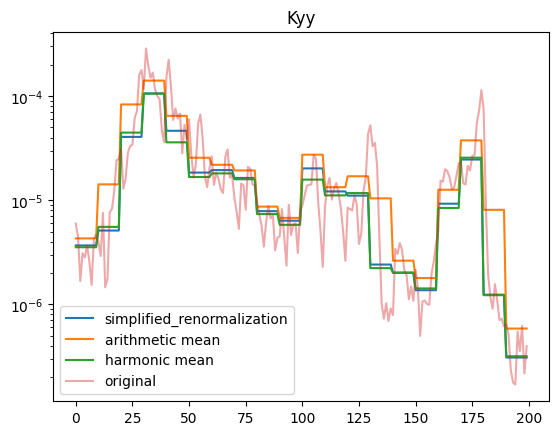

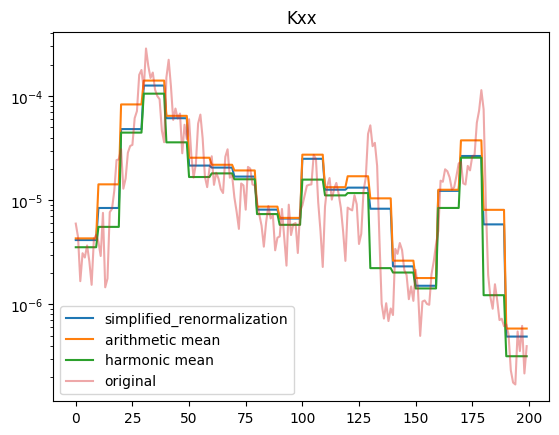

In [281]:
i = 90

plt.plot(new_field_kyy[:, i], label= "simplified_renormalization")
plt.plot(new_field_2_kyy[:, i], label="arithmetic mean")
plt.plot(new_field_2_kxx[:, i], label="harmonic mean")
plt.plot(field[0][:, i], label="original", alpha=.4)
plt.title("Kyy")
plt.legend()

plt.yscale("log")
plt.show()
plt.plot(new_field_kxx[:, i], label= "simplified_renormalization")
plt.plot(new_field_2_kyy[:, i], label="arithmetic mean")
plt.plot(new_field_2_kxx[:, i], label="harmonic mean")
plt.plot(field[0][:, i], label="original", alpha=.4)
plt.title("Kxx")
plt.legend()
plt.yscale("log")
plt.show()

In [233]:
cx_min, cx_max = find_c(selected_area, direction="x", first_type="series"), find_c(selected_area, direction="x", first_type="parallel")

In [234]:
1 / np.mean(1 / selected_area.flatten()), np.std(selected_area.flatten()), cx_min, cx_max

(2.660021320957124e-07,
 3.0560565742565557e-07,
 2.9886642360694397e-07,
 3.23751997659712e-07)

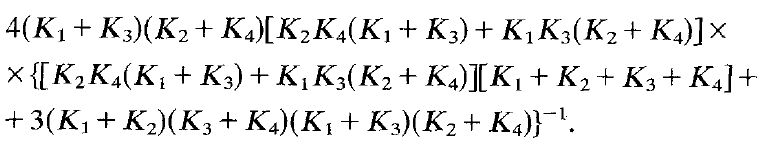

In [58]:
@jit
def f_sr(block):

    """
    Standard renormalization in 2D from King (1989).
    Takes a block of size 2X2 as input and output equivalent permeability
    """

    K1 = block[0, 0]
    K2 = block[0, 1]
    K3 = block[1, 0]
    K4 = block[1, 1]

    a = 4*(K1 + K3) * (K2 + K4)
    b = (K2 * K4 * (K1 + K3) + K1 * K3 * (K2 + K4))
    c = b*(K1 + K2 + K3 + K4) + 3 * (K1 + K2) * (K3 + K4) * (K1 + K3) * (K2 + K4)
    res = a * b * (1/c)
    return res


In [59]:
block = np.array([[3e-4, 1e-3], [4e-3, 1e-4]])

In [64]:
f_sr(block)

0.00038915079093634783

In [111]:
%%timeit
f(block, type="series")

5.43 µs ± 863 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [41]:
simplified_renormalization(block, 1, 1)

0.0005362769247617918